<a href="https://colab.research.google.com/github/brromeroc/Codigos-del-proyecto-Revision-de-conceptos-asociados-al-c-alculo-de-componentes-Principales/blob/main/VAEPROYECTODEGRADO_FASHION_DATASET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Arquitectura VAE**

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import tensorflow as tf
import keras
from keras import layers
import numpy as np
from scipy.optimize import minimize
import plotly.express as px
from PIL import Image
from numpy import linalg as LA

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Cuello de botella:**
 Para los codificadores automáticos variacionales, necesitamos definir la arquitectura de dos partes, codificador y decodificador, pero primero definiremos la capa de cuello de botella de la arquitectura, la capa de muestreo.


In [ ]:
class Sampling(layers.Layer):
    """Uses (mean, log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        mean, log_var = inputs
        batch = tf.shape(mean)[0]
        dim = tf.shape(mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return mean + tf.exp(0.5 * log_var) * epsilon

## **Codificador:**

Ahora, definimos la arquitectura de la parte del codificador de nuestro codificador automático, esta parte toma imágenes como entrada y codifica su representación en la capa de muestreo.

In [ ]:
latent_dim = 2  #Dimención espacio latente

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
mean = layers.Dense(latent_dim, name="mean")(x)
log_var = layers.Dense(latent_dim, name="log_var")(x)
z = Sampling()([mean, log_var])
encoder = keras.Model(encoder_inputs, [mean, log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 14, 14, 64)           640       ['input_5[0][0]']             
                                                                                                  
 conv2d_5 (Conv2D)           (None, 7, 7, 128)            73856     ['conv2d_4[0][0]']            
                                                                                                  
 flatten_2 (Flatten)         (None, 6272)                 0         ['conv2d_5[0][0]']            
                                                                                            

## **Decodificador:**

Ahora, definimos la arquitectura de la parte decodificadora de nuestro codificador automático, esta parte toma la salida de la capa de muestreo como entrada y genera una imagen de tamaño (28, 28, 1)



In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_5 (Dense)             (None, 3136)              9408      
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_6 (Conv2D  (None, 14, 14, 128)       73856     
 Transpose)                                                      
                                                                 
 conv2d_transpose_7 (Conv2D  (None, 28, 28, 64)        73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_8 (Conv2D  (None, 28, 28, 1)         577 

## **VAE**

En este paso, combinamos el modelo y definimos el procedimiento de entrenamiento con funciones de pérdida.

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            mean,log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * (1 + log_var - tf.square(mean) - tf.exp(log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# **Entrenar al VAE:**


##**Conjunto de datos fashion mnist**

Ahora veamos el conjunto de datos fashion mnist, en este hay imagnes de diferentes prendas, en total son $70000$ imagenes, estas se guardaran en el tensor  $fashion\_mnist$, que es de tamaño $70000\times 28\times 28$

In [ ]:
trainimages=1000
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()
fashion_mnist = np.concatenate([x_train, x_test], axis=0)
fashion_mnist=fashion_mnist[0:trainimages,:,:]   #estamos tomando las primeras 1000 imagenes para entrenar el modelo
fashion_mnist = np.expand_dims(fashion_mnist, 3).astype("float32") / 255

Ahora entrenamos el Vae con el conjunto de datos anterior, para esto utilizamos el optimizador *Adam* que es una variación del descenso del gradiente estocastico, utilizamos 1 epoca y la longitud del paso es de 32 (i.e el batch_size=32)

In [ ]:

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(fashion_mnist, epochs=10, batch_size=32)


Epoch 1/10
32/32 [==============================] - 6s 136ms/step - loss: 506.1318 - reconstruction_loss: 468.6889 - kl_loss: 0.2519
Epoch 2/10
32/32 [==============================] - 5s 164ms/step - loss: 398.0877 - reconstruction_loss: 389.7776 - kl_loss: 2.3553
Epoch 3/10
32/32 [==============================] - 4s 118ms/step - loss: 378.6570 - reconstruction_loss: 373.2554 - kl_loss: 3.4563
Epoch 4/10
32/32 [==============================] - 4s 120ms/step - loss: 368.8641 - reconstruction_loss: 359.9630 - kl_loss: 4.4760
Epoch 5/10
32/32 [==============================] - 6s 176ms/step - loss: 354.1464 - reconstruction_loss: 346.3129 - kl_loss: 6.4222
Epoch 6/10
32/32 [==============================] - 4s 124ms/step - loss: 337.5952 - reconstruction_loss: 322.4339 - kl_loss: 8.9722
Epoch 7/10
32/32 [==============================] - 4s 117ms/step - loss: 318.9305 - reconstruction_loss: 313.4315 - kl_loss: 8.0398
Epoch 8/10
32/32 [==============================] - 4s 129ms/step - l

Guardamos y Cargamos el decoder del VAE, que es el que nos interesa para nuestras aplicacions

In [ ]:
#Guardar decodificador
decoder.save('/content/drive/MyDrive/MODELOPROYECTODEGRADO/decoderfashion.h5')

In [ ]:
#cargar decodificador
decoderfashion = keras.models.load_model('/content/drive/MyDrive/MODELOPROYECTODEGRADO/decoderfashion.h5')



Acontinuación mostramos una de las imagenes correspondientes a este conjunto de datos:

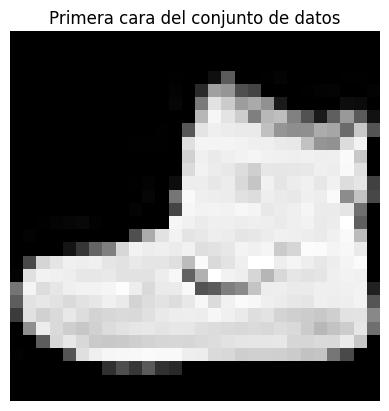

In [ ]:

plt.imshow(fashion_mnist[0,:,:,0], cmap="Greys_r")
plt.title("Primera cara del conjunto de datos")
plt.axis('off')
plt.show()




La siguiente es la imagen por medio del decoder correspondiente a la representación latente $(0,0)$, como vemos se intenta asemejar a una especie de vestido con ciertos rasgos de pantalon, esto tiene sentido por la teoria dado que la media esta centrada en $(0,0)$, asi este punto es muy versimil a cualquiera de las dos prendas

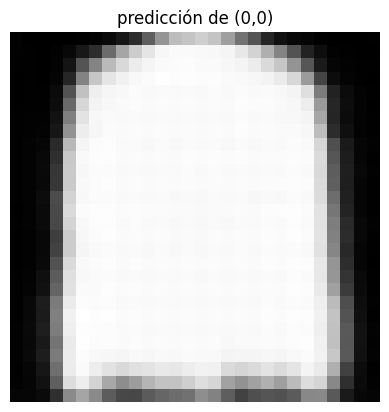

In [ ]:
I=decoderfashion.predict([[0  , 0]], verbose=0)
plt.imshow(I[0,:,:,0], cmap="Greys_r")
plt.title("predicción de (0,0)")
plt.axis('off')
plt.show()

**Mostrar Datos:**

En este paso, mostramos los resultados del entrenamiento, colacaremos, las imagenes de acuerdo a su posición en el espacio latente.

In [ ]:


import matplotlib.pyplot as plt

def plot_latent_space(vae, n=10, figsize=5):
    # display a n*n 2D manifold of images
    img_size = 28
    scale = 0.5
    figure = np.zeros((img_size * n, img_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of images classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            sample = np.array([[xi, yi]])
            x_decoded = decoderfashion.predict(sample, verbose=0)
            images = x_decoded[0].reshape(img_size, img_size)
            figure[
                i * img_size : (i + 1) * img_size,
                j * img_size : (j + 1) * img_size,
            ] = images

    plt.figure(figsize=(figsize, figsize))
    start_range = img_size // 2
    end_range = n * img_size + start_range
    pixel_range = np.arange(start_range, end_range, img_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

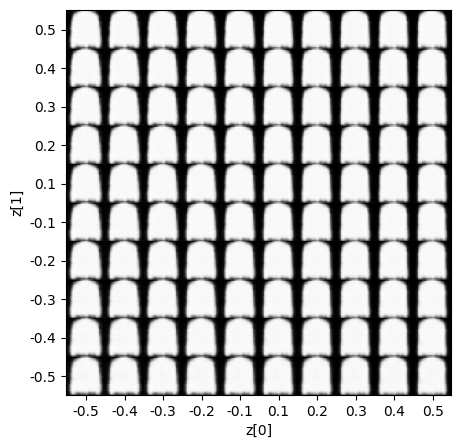

In [ ]:
plot_latent_space(decoderfashion)

Por último colocarmos como se distrtibuyen los datos de entrada, en el espacio latente, obbservamos que la mayoria parecira estar sobre una reecta oblicua, concentrado mayoritariamente en el centro, esto de acuerdo a la teoria es bastante bueno.

In [ ]:
def plot_label_clusters(encoder, decoder, data):
    z_mean,log_var, z = encoder.predict(data)
    plt.figure(figsize =(12, 10))
    sc = plt.scatter(z_mean[:, 0], z_mean[:, 1])
    cbar = plt.colorbar(sc, ticks = range(10))
    #cbar.ax.set_yticklabels([labels.get(i) for i in range(10)])
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

32/32 [==============================] - 0s 13ms/step


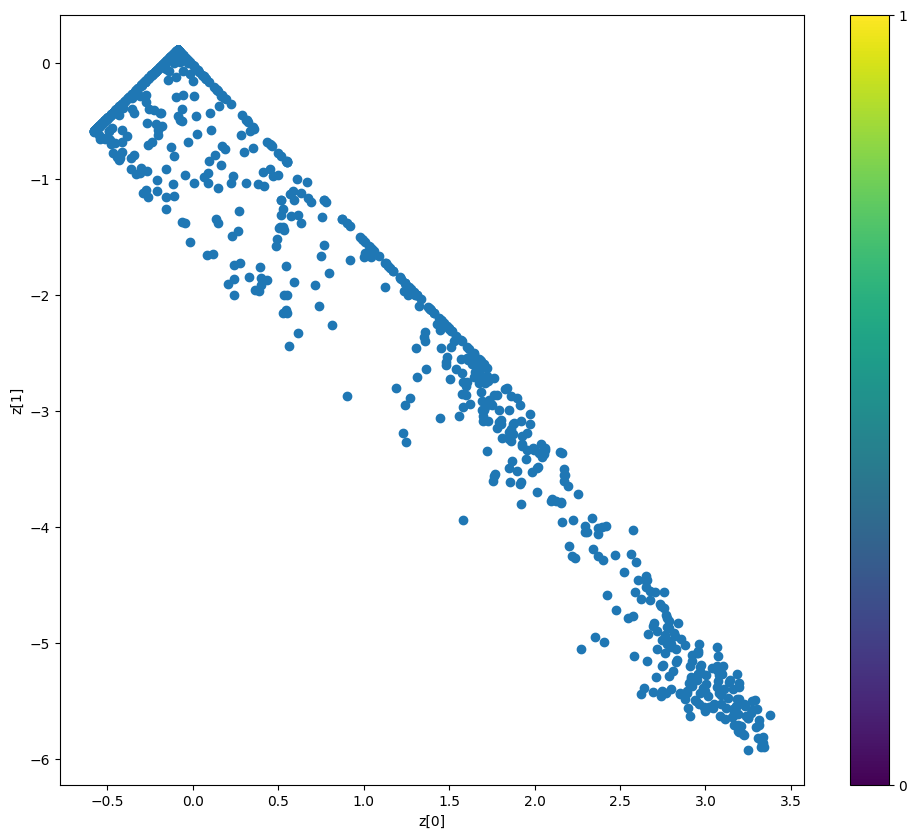

In [ ]:
#x_train = np.expand_dims(fashion_mnist, -1).astype("float32") / 255
plot_label_clusters(encoder, decoder, fashion_mnist)

#**Metodo proyectado de potencias (Ppower)**

Ahora implementamos el Metodo proyectado de potencias, ver referencias [2], Para encontrar los valores y vectores propios de la matriz de covarianza $\Sigma_r=M^TM$,Donde $M$ es la matriz de tamaño $821\times 728$. El método consiste en hacer la iteración:


 $$w^{(t+1)}=\mathcal{P}_G(\Sigma_r w^{(t)})$$     


 Donde $G(x)=\frac{\hat{G}(x)}{||\hat{G}(x)||_2}$, es la normalización de nuestro  decoder  $\hat{G}$, y

 $$\mathcal{P}_G(x)=\arg\min_{w\in Im(G)}||x-w||_2$$

 Ahora esto último hallara el vector propio asociado al  valor propio de mayor magnitud,  para hallar los otros aplicaremos deflación de matrices, y luego volveremos aplicar la primera ecuación, esta vez a la matriz deflacionada

In [ ]:
def G(z,decoder): #Definimos el modelo normalizado
 t = np.array([z]) #Transforma a una lista de listas que es lo que toma el decoder
 w=decoder.predict(t,verbose=0).reshape(784) #transforma el tensor a un vector
 y=w/LA.norm(w)   #normaliza
 return y

def distan(z,x,decoder): #Función a optimizar  #tanto x como z con np.arrays pero en distiantas dimenciones
 normxw=LA.norm(x-G(z,decoder))
 return normxw

In [ ]:
def constraint(z): #Restricciones para el problema de optimización
  return 100000 - LA.norm(z)


def Proyection(x,decoder): #Proyección sobre la imagen del VAE normalizado
  cons = ({'type': 'ineq', 'fun': constraint})
  z0 = 10*np.random.rand(latent_dim)  # Punto inicial aleatorio
  res = minimize(distan, z0, args=(x, decoder), constraints=cons,tol=0.00001)
  proy=G(res.x,decoder)
  return proy

In [ ]:
def Ppower(w0,num_iterations, Sigma,decoder): #Iteracion del metodo de potencias proyectado (Ppower)
 for i in range(num_iterations):
   w0=Proyection(Sigma@w0,decoder)
 lammbda=w0@Sigma@w0
 return lammbda,w0

def Ppower_iteration_deflacion(k, num_iterations,Sigma,w0,decoder): #Ppower con deflación de matriz
  s = Sigma.shape[0]
  v = np.zeros(k)
  V = np.zeros((s,k))
  A0 = Sigma
  for i in range(k):
    eigenval , eigenvec = Ppower(w0, num_iterations,A0,decoder)
    v[i] = eigenval
    V[:,i] = eigenvec
    A0  = A0 - eigenval * np.outer(eigenvec, eigenvec)
  return(v,V)


##**Ejemplo para el conjunto de datos fasionmnist**

En este emplo mostramos el calculo de los vectores propis dominantes de la matriz de $\Sigma_r=M^TM$ donde $M$ es la matriz de datos *fashion_mnist* (para efectos practicos y que el programa se ejcute un poco mas rapido no consideramos las $70000$ imagenes si no solo $1000$) tanto con numpy como con Ppower

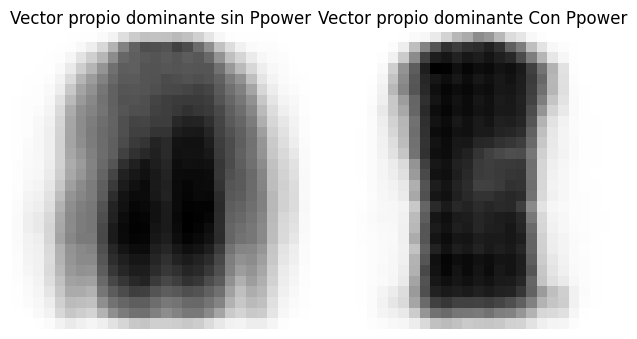

In [ ]:
imgs=400
iteraciones=50
Mfashion=fashion_mnist.reshape(trainimages,784)[0:imgs,0:784]
Sigmafashion=np.transpose(Mfashion)@Mfashion

# Calcula los valores y vectores propios con numpy
valores_propios, vectores_propios = np.linalg.eig(Sigmafashion)
indices_ordenados = np.argsort(np.abs(valores_propios))[::-1]
valores_ordenados = valores_propios[indices_ordenados]
vectores_ordenados = vectores_propios[:, indices_ordenados]

#calcula el mayor valor propio y su vector asociado
mayor_vector= vectores_ordenados[:, 0]

#calcula el mayor valor propio y su vector asociado con Ppower
mayor_vector_ppower_fashion=Ppower(np.random.rand(784),iteraciones,Sigmafashion,decoderfashion)

#Imprimimos los resultados
plt.subplot(1, 2, 1)
plt.imshow(mayor_vector.reshape(28,28), cmap="Greys_r")
plt.title("Vector propio dominante sin Ppower")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(-mayor_vector_ppower_fashion[1].reshape(28,28), cmap="Greys_r")
plt.title("Vector propio dominante Con Ppower")
plt.axis('off')

plt.tight_layout()

plt.show()

In [ ]:
valoresppower,vectoresppower=Ppower_iteration_deflacion(10,iteraciones,Sigmafashion,np.random.rand(784),decoderfashion)

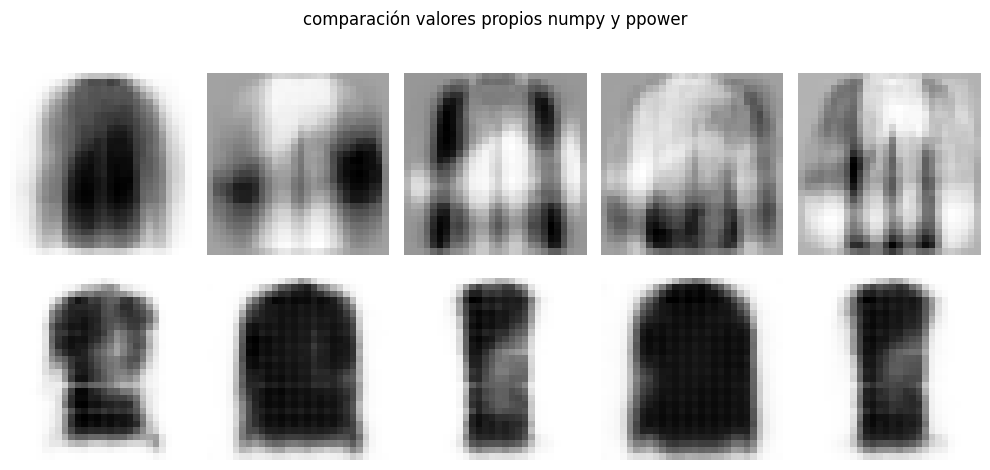

In [ ]:
plt.figure(figsize=(10, 5))


for i in range(1,11):
  if i<6:
    plt.subplot(2, 5, i)
    plt.imshow(vectores_ordenados[:,i-1].reshape(28,28), cmap="Greys_r")
    plt.axis('off')

  else:
    plt.subplot(2, 5, i)
    plt.imshow(-vectoresppower[:,i-1].reshape(28,28), cmap="Greys_r")
    plt.axis('off')

plt.suptitle("comparación valores propios numpy y ppower")
plt.tight_layout()
plt.show()


#**Referencias**

1. https://www.geeksforgeeks.org/variational-autoencoders/
2. Z. Li, J. Liu, S. Ghosh, J. Han, and J. Scarlett, “Generative principal component
analysis,” Applied Numerical Mathematics, vol. 169, 2021
3. Redes neuronales convolucionales: https://medium.com/@beingfarina/breaking-down-the-mathematics-behind-cnn-models-a-comprehensive-guide-1853aa6b011e
4. UnderstandingDeepLearning, Redes convolucionales pag 170: https://udlbook.github.io/udlbook/